In [1]:
# Read in ground truth user click data for the week of 11-11 ~ 11-17
import pandas as pd

exported_data_folder = "/home/sun00587/research/News_Locality_Polarization/Data/POPROX_data/dataset_20241118-202624"
clicks_path = "{}/clicks_20241118-204103.parquet".format(exported_data_folder)
article_path = "{}/articles_20241118-202859.parquet".format(exported_data_folder)
click_df = pd.read_parquet(clicks_path)
article_df = pd.read_parquet(article_path)

click_df = click_df.dropna()
click_df["timestamp"] = pd.to_datetime(click_df["timestamp"])
article_df["published_at"] = pd.to_datetime(article_df["published_at"])

START_DATE, END_DATE = "2024-11-11", "2024-11-17"
week_articles = article_df[
    (article_df["published_at"].dt.date >= pd.to_datetime(START_DATE).date())
    & (article_df["published_at"].dt.date <= pd.to_datetime(END_DATE).date())
]
len(week_articles)

817

In [2]:
ground_truth_clicks = click_df.merge(week_articles, how="left", on="article_id").dropna()
gorund_truth_gb = ground_truth_clicks.groupby("profile_id")
ground_truth_clicks["profile_id"].describe()

count                                      182
unique                                      20
top       127902af-2e1f-4a4e-ba1c-b1a4e7f4e762
freq                                        31
Name: profile_id, dtype: object

In [3]:
import glob
from collections import defaultdict


def compute_recall(theta_recs_path):
    rec_files = glob.glob("{}*.parquet".format(theta_recs_path))
    user_rec_recall = defaultdict(dict)  # key: userId, val: dict[key: (theta_topic, theta_locality), val: recall
    for file in rec_files:
        df = pd.read_parquet(file)
        df_gb = df.groupby("user")
        for user, rec_df in df_gb:
            if user in gorund_truth_gb.groups:
                rec_df = rec_df[rec_df["stage"] == "final"]  # final is the same as reranked in our case
                clicked = rec_df["item"].isin(gorund_truth_gb.get_group(user)["article_id"]).sum()
                recall = clicked / len(rec_df)

                file_name_items = file.split("/")[-1].split("_")
                theta_top, theta_loc = file_name_items[1], file_name_items[3][:-8]
                user_rec_recall[user]["top_{}_loc_{}".format(theta_top, theta_loc)] = recall
    return user_rec_recall

In [4]:
def add_recall(row, user_rec_recall):
    for top_loc in user_rec_recall[row["uuid"]]:
        tokens = top_loc.split("_")
        top, loc = float(tokens[1]), float(tokens[3])
        if row["top_num"] == str(top) and row["loc_num"] == str(loc):
            return user_rec_recall[row["uuid"]][top_loc]
    return -1

In [5]:
week_recall_kl_dfs = []
for i in range(1, 8):
    theta_recs_path = "/home/sun00587/research/News_Locality_Polarization/poprox-recommender-locality/outputs/theta_grid_search_11-1{}/".format(
        i
    )
    theta_kl_value_path = "/home/sun00587/research/News_Locality_Polarization/poprox-recommender-locality/outputs/theta_kl_values_11-1{}.txt".format(
        i
    )
    user_rec_recall = compute_recall(theta_recs_path)

    kl_df = pd.read_csv(theta_kl_value_path)
    kl_df = kl_df[kl_df["profile_id"].str.startswith(tuple(list(user_rec_recall.keys())))]
    kl_df["uuid"] = kl_df["profile_id"].str.extract(r"(^[a-f0-9\-]+)")
    kl_df[["top_num", "loc_num"]] = kl_df["profile_id"].str.extract(r"top_([\d.]+)_loc_([\d.]+)")

    kl_df["recall"] = kl_df.apply(add_recall, axis=1, args=(user_rec_recall,))
    kl_recall_kl_df = kl_df[kl_df.recall != -1]

    week_recall_kl_dfs.append(kl_recall_kl_df)

print(len(week_recall_kl_dfs))
print(week_recall_kl_dfs[0].head())

7
                                          profile_id    kl_top    kl_loc  \
0  2e684947-81c6-4139-b379-4c6627097015_top_0.0_l...  1.511320  0.293461   
1  f2de35e8-5afe-4742-a5ff-e3485a8e662c_top_0.0_l...  1.479891  0.353937   
3  f81c93e1-4aef-4d88-b5e3-7730a76279a9_top_0.0_l...  0.957602  0.207033   
5  7d71dff0-5cef-44f0-9d92-4d85e4ee1afa_top_0.0_l...  0.619537  1.581303   
6  de2601b9-77f3-464e-a3c2-86791f884321_top_0.0_l...  1.368460  1.612544   

                                   uuid top_num loc_num  recall  
0  2e684947-81c6-4139-b379-4c6627097015     0.0     0.0     0.1  
1  f2de35e8-5afe-4742-a5ff-e3485a8e662c     0.0     0.0     0.0  
3  f81c93e1-4aef-4d88-b5e3-7730a76279a9     0.0     0.0     0.0  
5  7d71dff0-5cef-44f0-9d92-4d85e4ee1afa     0.0     0.0     0.0  
6  de2601b9-77f3-464e-a3c2-86791f884321     0.0     0.0     0.0  


In [6]:
combined_df = pd.concat(week_recall_kl_dfs, ignore_index=True)

# Group by `uuid`, `top_num`, and `loc_num`, then calculate the mean of `kl_top`, `kl_loc`, and `recall`
result_df = combined_df.groupby(["uuid", "top_num", "loc_num"], as_index=False)[["kl_top", "kl_loc", "recall"]].mean()
result_df.head()

,uuid,top_num,loc_num,kl_top,kl_loc,recall
0,0972251f-5e75-401f-a7bd-0d8dce06b4d7,0.0,0.0,1.442504,1.164339,0.0
1,0972251f-5e75-401f-a7bd-0d8dce06b4d7,0.0,0.05,1.358743,0.350901,0.0
2,0972251f-5e75-401f-a7bd-0d8dce06b4d7,0.0,0.1,1.370241,0.247950,0.0
3,0972251f-5e75-401f-a7bd-0d8dce06b4d7,0.0,0.2,1.381593,0.114394,0.0
4,0972251f-5e75-401f-a7bd-0d8dce06b4d7,0.0,0.25,1.404049,0.083090,0.0


In [7]:
# Group by `top_num` and `loc_num` and calculate the mean of `kl_top`, `kl_loc`, and `recall` among all users
final_result_df = result_df.groupby(["top_num", "loc_num"], as_index=False)[["kl_top", "kl_loc", "recall"]].mean()
final_result_df.head()

,top_num,loc_num,kl_top,kl_loc,recall
0,0.0,0.0,1.095075,0.791806,0.042063
1,0.0,0.05,1.001594,0.259380,0.041270
2,0.0,0.1,0.986417,0.156962,0.039683
3,0.0,0.2,0.961399,0.098648,0.038889
4,0.0,0.25,0.969264,0.073208,0.038095


In [8]:
# Find min and max for `kl_top`
kl_top_min = final_result_df.loc[final_result_df["kl_top"].idxmin()]
kl_top_max = final_result_df.loc[final_result_df["kl_top"].idxmax()]

# Find min and max for `kl_loc`
kl_loc_min = final_result_df.loc[final_result_df["kl_loc"].idxmin()]
kl_loc_max = final_result_df.loc[final_result_df["kl_loc"].idxmax()]

# Find min and max for `recall`
recall_min = final_result_df.loc[final_result_df["recall"].idxmin()]
recall_max = final_result_df.loc[final_result_df["recall"].idxmax()]

# Print results
print("Minimum and Maximum Values with Corresponding Pairs:")
print("kl_top_min:", kl_top_min.to_dict())
print("kl_top_max:", kl_top_max.to_dict())
print("kl_loc_min:", kl_loc_min.to_dict())
print("kl_loc_max:", kl_loc_max.to_dict())
print("recall_min:", recall_min.to_dict())
print("recall_max:", recall_max.to_dict())

Minimum and Maximum Values with Corresponding Pairs:
kl_top_min: {'top_num': '1.0', 'loc_num': '0.0', 'kl_top': 0.14470800793561386, 'kl_loc': 0.6305901484980371, 'recall': 0.01904761904761905}
kl_top_max: {'top_num': '0.0', 'loc_num': '1.0', 'kl_top': 1.2330506951373414, 'kl_loc': 0.0041072912012763575, 'recall': 0.010317460317460317}
kl_loc_min: {'top_num': '0.0', 'loc_num': '1.0', 'kl_top': 1.2330506951373414, 'kl_loc': 0.0041072912012763575, 'recall': 0.010317460317460317}
kl_loc_max: {'top_num': '0.0', 'loc_num': '0.0', 'kl_top': 1.095075016315164, 'kl_loc': 0.7918064176738789, 'recall': 0.04206349206349207}
recall_min: {'top_num': '0.55', 'loc_num': '0.65', 'kl_top': 0.3192740563564314, 'kl_loc': 0.017108666970905954, 'recall': 0.002380952380952381}
recall_max: {'top_num': '0.0', 'loc_num': '0.0', 'kl_top': 1.095075016315164, 'kl_loc': 0.7918064176738789, 'recall': 0.04206349206349207}


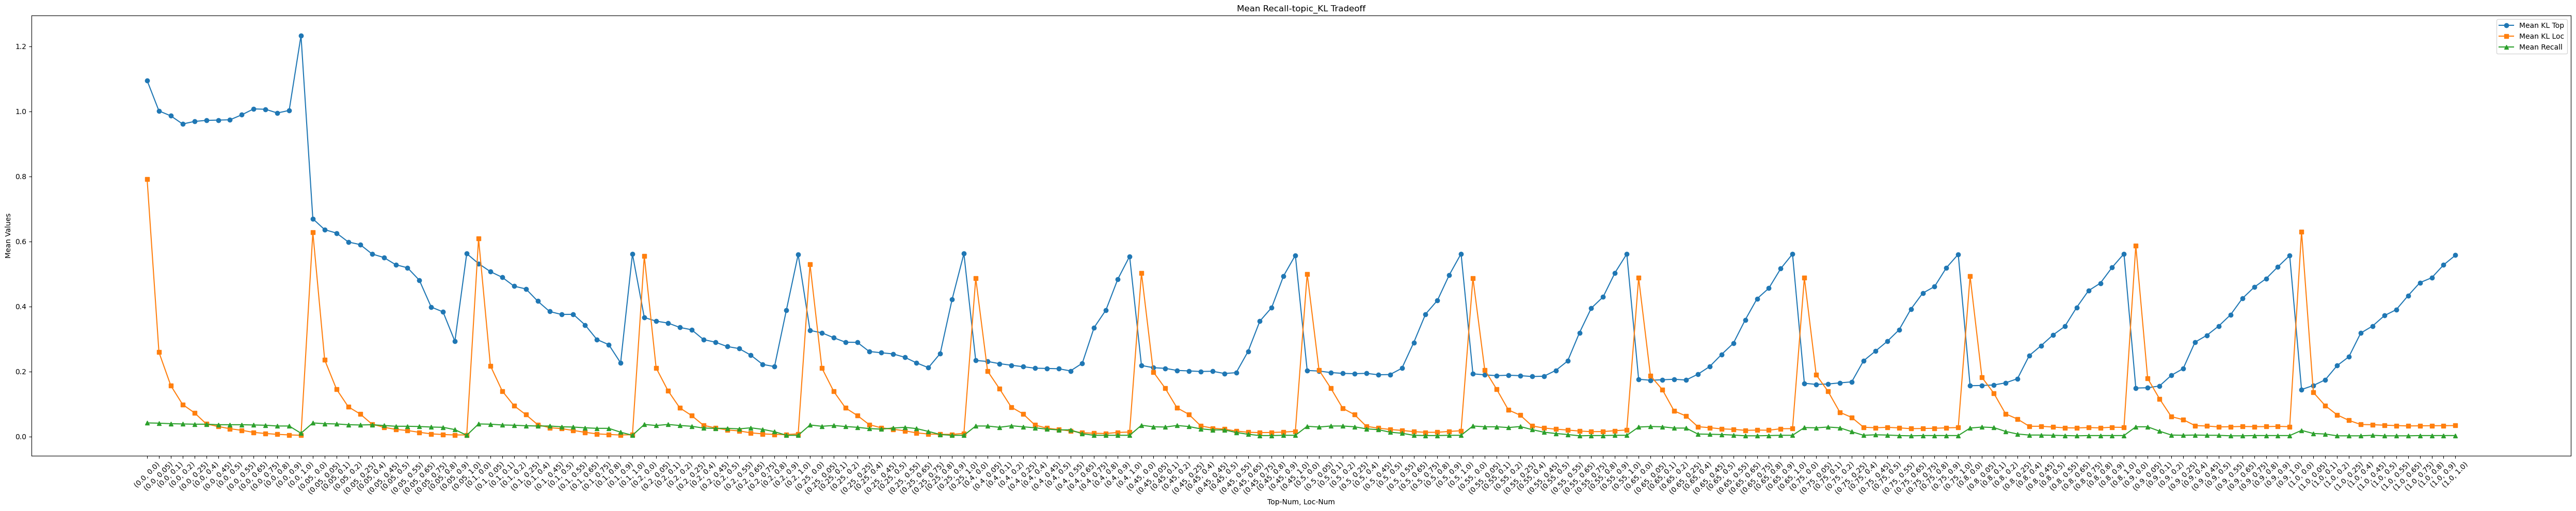

In [9]:
import matplotlib.pyplot as plt

final_result_df["x_axis"] = final_result_df.apply(lambda row: f"({row['top_num']}, {row['loc_num']})", axis=1)

aggregated_df = (
    final_result_df.groupby("x_axis")
    .agg(mean_kl_top=("kl_top", "mean"), mean_kl_loc=("kl_loc", "mean"), mean_recall=("recall", "mean"))
    .reset_index()
)

# Plotting
plt.figure(figsize=(50, 10))  # Adjust size for better visibility
plt.plot(aggregated_df["x_axis"], aggregated_df["mean_kl_top"], marker="o", label="Mean KL Top")
plt.plot(aggregated_df["x_axis"], aggregated_df["mean_kl_loc"], marker="s", label="Mean KL Loc")
plt.plot(aggregated_df["x_axis"], aggregated_df["mean_recall"], marker="^", label="Mean Recall")

# Adding labels and title
plt.xlabel("Top-Num, Loc-Num")
plt.ylabel("Mean Values")
plt.title("Mean Recall-topic_KL Tradeoff")
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()